In [25]:
import torch
from torch import nn
from d2l import torch as d2l

# 做一个数据集
n_train = 50
x_train, _ = torch.sort(torch.rand(n_train) * 5) # 排序后的训练样本

def f(x):
    return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, )) # 训练标签
x_test = torch.arange(0, 5, 0.1) # 测试样本
y_truth = f(x_test)
n_test = len(x_test) # 50

def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

平均汇聚

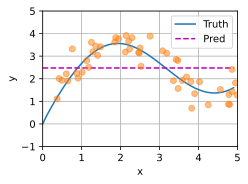

In [26]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

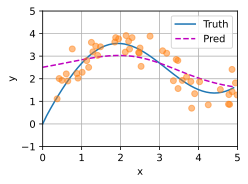

In [27]:
# X_repeat的形状：(n_test, n_train)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# x_train包含着键。attention_weights的形状:(n_test, n_train)
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
attention_weights.shape
y_hat = torch.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

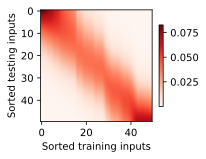

In [28]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

带参数的注意力汇聚

In [29]:
X = torch.ones((2, 1, 4))
Y = torch.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [30]:
weights = torch.ones((2, 10)) * 0.1 
values = torch.arange(20.0).reshape((2, 10))
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

In [31]:
# 定义模型
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True))
        
    def forward(self, queries, keys, values):
        queries = queries.repeat_interleave(keys.shape[1]).reshape((-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1
        )
        # values的形状为：（查询个数，“键-值”个数）
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1)

训练

In [32]:
X_tile = x_train.repeat((n_train, 1))
Y_tile = y_train.repeat((n_train, 1))
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))

训练带参数的注意力汇聚模型，使用平方损失函数和随机梯度下降

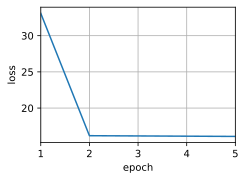

In [33]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epch{epoch+1}, loss{float(l.sum()):.6f}')
    animator.add(epoch+1, float(l.sum()))

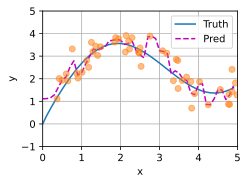

In [34]:
keys = x_train.repeat((n_train, 1))
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

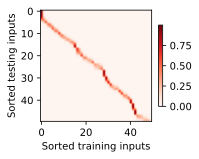

In [35]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')